# Neural CDE for regression problems

This example trains a Neural CDE (a "continuous time RNN") to reproduce a toy dataset of nonlinear oscillators.

A neural CDE looks like

$y(t) = y(0) + \int_0^t f_\theta(y(s)) \mathrm{d}x(s)$

Where $f_\theta$ is a neural network, and $x$ is your data. The right hand side is a matrix-vector product between them. The integral is a Riemann--Stieltjes integral.



Provided the path $x$ is differentiable then the Riemann--Stieltjes integral can be converted into a normal integral:

$y(t) = y(0) + \int_0^t f_\theta(y(s)) \frac{\mathrm{d}x}{\mathrm{d}s}(s) \mathrm{d}s$

and in this case you can actually solve the CDE as an ODE. Indeed this is what we do below.

Typically the path $x$ is constructed as a continuous interpolation of your input data. This is an approach that often makes a lot of sense when dealing with irregular data, densely sampled data etc. (i.e. the things that an RNN or Transformer might not work so well on.)

**Reference:**

```bibtex
@incollection{kidger2020neuralcde,
    title={Neural Controlled Differential Equations for Irregular Time Series},
    author={Kidger, Patrick and Morrill, James and Foster, James and Lyons, Terry},
    booktitle={Advances in Neural Information Processing Systems},
    publisher={Curran Associates, Inc.},
    year={2020},
}
```


In [1]:
import os
import jax
jax.config.update("jax_enable_x64", True)
os.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=16"
jax.config.update("jax_platform_name", "cpu")  # Ensure running on CPU

import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax.nn as jnn
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax


import matplotlib.pyplot as plt

In [2]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP
    data_size: int
    hidden_size: int

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.data_size = data_size
        self.hidden_size = hidden_size
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=hidden_size * data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            # Note the use of a tanh final activation function. This is important to
            # stop the model blowing up. (Just like how GRUs and LSTMs constrain the
            # rate of change of their hidden states.)
            # final_activation=jnn.tanh,
            key=key,
        )

    def __call__(self, t, y, args):

        F = self.mlp(y[1:]).reshape(self.hidden_size, self.data_size)
        m, n = F.shape
        # Create a new matrix with dimensions (m+1, n+1)
        f = jnp.zeros((m+1, n+1))
        # Set the top-left corner to 1
        f = f.at[0,0].set(1)
        # Place the original matrix F in the bottom right corner
        f = f.at[1:, 1:].set(F)

        return f

Here we wrap up the entire ODE solve into a model.

In [3]:
class NeuralCDE(eqx.Module):
    # initial: eqx.nn.MLP
    func: Func

    def __init__(self, data_size,  hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        ikey, fkey, lkey = jr.split(key, 3)
        # self.initial = eqx.nn.MLP(data_size+1, hidden_size+1, width_size, depth, key=ikey)
        self.func = Func(data_size,  hidden_size, width_size, depth, key=fkey)

    def __call__(self, ts, y0, coeffs):
        control = diffrax.CubicInterpolation(ts, coeffs)
        term = diffrax.ControlTerm(self.func, control).to_ode()
        solver = diffrax.Euler()

        # adjoint_controller = diffrax.PIDController(norm=diffrax.adjoint_rms_seminorm)
        # adjoint = diffrax.BacksolveAdjoint(stepsize_controller=adjoint_controller)
        
        adjoint=diffrax.RecursiveCheckpointAdjoint()
        dt0 = ts[1]-ts[0]
        # print(dt0)
        # y0 = jnp.concatenate([ts[0], y0])
        # y0 = self.initial(control.evaluate(ts[0]))
        saveat=diffrax.SaveAt(ts=ts)
        solution = diffrax.diffeqsolve(
            term,
            solver,
            ts[0],
            ts[-1],
            dt0,
            y0,
            # stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6),
            saveat=saveat,
            adjoint=adjoint,
        )

        return solution.ys

Toy dataset of nonlinear oscillators. Sample paths look like deformed sines and cosines.

In [4]:
def _get_data(ts, *, key):
    
    y0_key, x0_key = jr.split(key, 2)
    x0 = jr.uniform(x0_key, (2,), minval=-0.6, maxval=1)
    y0 = jr.uniform(y0_key, (2,), minval=-0.6, maxval=1)
    
    # Add zero at the beginning
    y0 = jnp.concatenate([jnp.array([0.]), y0])

    # Define the vector field f(y) for the CDE
    def vector_field(t, y, args):
        
        ys= y[1:]
        F = jnp.array([[ys[0], ys[1]], [ys[1], -ys[0]]])

        m, n = F.shape
        # Create a new matrix with dimensions (m+1, n+1)
        f = jnp.zeros((m+1, n+1))
        # Set the top-left corner to 1
        f = f.at[0,0].set(1)
        # Place the original matrix F in the bottom right corner
        f = f.at[1:, 1:].set(F)

        return f

    # Generate sinusoidal trajectories with phase shifts
    xs = jnp.stack([
        jnp.sin(2 * jnp.pi * ts + x0[0]),
        jnp.sin(2 * jnp.pi * ts + x0[1])
    ], axis=-1)

    # ts = jnp.broadcast_to(ts, (dataset_size, length))
    xs = jnp.concatenate([ts[:, None], xs], axis=-1)  # time is a channel
 
    # coeffs = jax.vmap(diffrax.backward_hermite_coefficients)(ts, xs)

    coeffs = diffrax.backward_hermite_coefficients(ts, xs)    
    control = diffrax.CubicInterpolation(ts, coeffs)    
    term = diffrax.ControlTerm(vector_field, control).to_ode()

    solver = diffrax.Euler()
    dt0 = ts[1] - ts[0]
    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(
            term,
            solver,
            ts[0],
            ts[-1],
            dt0,
            y0,
            # stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6),
            saveat=saveat,
            # adjoint=diffrax.RecursiveCheckpointAdjoint(),
        )

    ys = sol.ys
    return ts, ys, coeffs


def get_data(dataset_size, *, key):
    ts = jnp.linspace(0, 2, 100)
    key = jr.split(key, dataset_size)
    ts, ys, coeffs = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys, coeffs

In [ ]:
# # Generate data
# key = jr.PRNGKey(42)
# dataset_size = 100  # Generate 5 trajectories for visualization
# ts, yts, coeffs = get_data(dataset_size, key=key)

# ys=yts[:, :, 1:]

# # Create figure with subplots
# fig = plt.figure(figsize=(15, 10))

# # Plot individual components over time
# ax1 = plt.subplot(2, 2, 1)
# ax2 = plt.subplot(2, 2, 2)
# ax3 = plt.subplot(2, 2, (3, 4))  # Phase space plot takes bottom half

# # Plot first component
# for i in range(dataset_size):
#     ax1.plot(ts[i, :], ys[i, :, 0], label=f'Trajectory {i+1}')
# ax1.grid(True)
# ax1.set_xlabel('Time')
# ax1.set_ylabel('y₁(t)')
# ax1.set_title('First Component')
# ax1.legend()

# # Plot second component
# for i in range(dataset_size):
#     ax2.plot(ts[i, :], ys[i, :, 1], label=f'Trajectory {i+1}')
# ax2.grid(True)
# ax2.set_xlabel('Time')
# ax2.set_ylabel('y₂(t)')
# ax2.set_title('Second Component')
# ax2.legend()

# # Phase space plot
# for i in range(dataset_size):
#     ax3.plot(ys[i, :, 0], ys[i, :, 1], label=f'Trajectory {i+1}')
#     # Mark start point
#     ax3.plot(ys[i, 0, 0], ys[i, 0, 1], 'go', markersize=8, label='Start' if i == 0 else "")
#     # Mark end point
#     ax3.plot(ys[i, -1, 0], ys[i, -1, 1], 'ro', markersize=8, label='End' if i == 0 else "")

# ax3.grid(True)
# ax3.set_xlabel('y₁')
# ax3.set_ylabel('y₂')
# ax3.set_title('Phase Space')
# ax3.legend()

# # Add arrows to show direction of trajectories
# for i in range(dataset_size):
#     # Add arrows at regular intervals
#     n_arrows = 5
#     idx = len(ts) // n_arrows
#     for j in range(n_arrows):
#         k = j * idx
#         if k + idx < len(ts):
#             dx = ys[i, k + idx, 0] - ys[i, k, 0]
#             dy = ys[i, k + idx, 1] - ys[i, k, 1]
#             ax3.arrow(ys[i, k, 0], ys[i, k, 1], dx/2, dy/2,
#                      head_width=0.05, head_length=0.08, fc='k', ec='k', alpha=0.5)

# plt.tight_layout()
# plt.show()

# # Print some statistical information
# print("\nTrajectory Statistics:")
# print("-" * 50)
# for i in range(dataset_size):
#     print(f"\nTrajectory {i+1}:")
#     print(f"Initial position: ({ys[i,0,0]:.3f}, {ys[i,0,1]:.3f})")
#     print(f"Final position: ({ys[i,-1,0]:.3f}, {ys[i,-1,1]:.3f})")
#     print(f"Maximum y₁: {jnp.max(ys[i,:,0]):.3f}")
#     print(f"Maximum y₂: {jnp.max(ys[i,:,1]):.3f}")
#     print(f"Minimum y₁: {jnp.min(ys[i,:,0]):.3f}")
#     print(f"Minimum y₂: {jnp.min(ys[i,:,1]):.3f}")

In [5]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

Main entry point. Try runnning `main()`.

Step: 0, Loss: 0.909423262937247, Computation time: 6.530407905578613
Step: 19, Loss: 0.6966697388078655, Computation time: 0.12367010116577148
Step: 0, Loss: 0.5231774917740689, Computation time: 6.084428310394287
Step: 50, Loss: 0.29922632947220296, Computation time: 0.46871232986450195
Step: 100, Loss: 0.03243701115484453, Computation time: 0.4756460189819336
Step: 150, Loss: 0.004493337937267394, Computation time: 0.4605753421783447
Step: 200, Loss: 0.004528546080002472, Computation time: 0.44806337356567383
Step: 250, Loss: 0.0020742019245922477, Computation time: 0.35741615295410156
Step: 300, Loss: 0.0017653071217024034, Computation time: 0.4903268814086914
Step: 350, Loss: 0.000592855348064115, Computation time: 0.43964481353759766
Step: 400, Loss: 0.000317108435397987, Computation time: 0.4532477855682373
Step: 450, Loss: 0.00039041117211202896, Computation time: 0.3245429992675781
Step: 500, Loss: 0.00029754895786503546, Computation time: 0.412477970123291
Step: 550, Loss: 0.

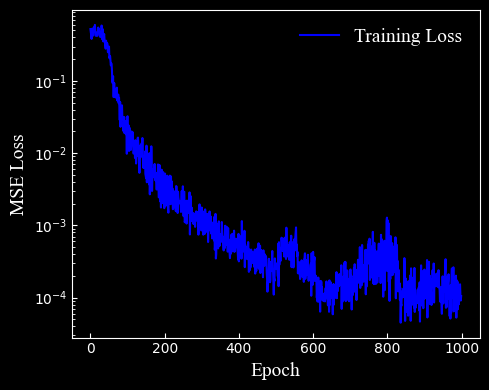

In [6]:
def main(
    dataset_size=1000,
    batch_size=64,
    lr_strategy=(1e-2, 1e-3),
    steps_strategy=(20, 1000),
    length_strategy=(0.2, 1),
    hidden_size=2,
    width_size=128,
    depth=3,
    seed=5678,
    plot=True,
    print_every=50,
):
    key = jr.PRNGKey(seed)
    
    data_key, model_key, loader_key = jr.split(key, 3)

    ts, ys, coeffs= get_data(dataset_size, key=data_key)
    _, length_size, data_size = ys[:, :, 1:].shape

    model = NeuralCDE(data_size, hidden_size, width_size, depth, key=model_key)

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi, coeff_i):
        # y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])

        y_pred = jax.vmap(model, in_axes=(None, 0, 0))(ti[0], yi[:, 0], coeff_i)

        return jnp.mean((yi[:, :, 1:] - y_pred[:, :, 1:]) ** 2)

    @eqx.filter_jit
    def make_step(data_i, model, opt_state):
        ti, yi, *coeff_i = data_i
        
        loss, grads = grad_loss(model, ti, yi, coeff_i)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state
    
    # training
    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

        _ts = ts[:, : int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]

        _coeffs = tuple(arr[:, : int(length_size * length)-1, :] for arr in coeffs)

        train_losses = []
        for step, data_i, in zip(
        range(steps), dataloader((_ts,_ys) + _coeffs, batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state = make_step(data_i, model, opt_state)
            end = time.time()

            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")
            train_losses.append(loss)
    if plot:
        plt.figure(figsize=(5, 4))
        plt.plot(train_losses , label='Training Loss', color='blue')
        plt.yscale('log')
        plt.xlabel('Epoch', fontsize=14, fontname='Times New Roman')
        plt.ylabel('MSE Loss', fontsize=14, fontname='Times New Roman')
        plt.tick_params(axis='both', which='major', direction='in')
        plt.tick_params(axis='both', which='minor', direction='in')
        # plt.autoscale(tight=True)
        plt.legend(prop={'family': 'Times New Roman', 'size': 14}, frameon=False)
        plt.tight_layout()
        plt.show()

    return ts, ys, model, train_losses

ts, ys, model, train_losses = main()

[3698752877 2485265801] [  0 366]
(1, 100)
(1, 100)
(1, 100, 3)
(1, 99, 3)
(100, 3)
(100, 3)


C:\Users\lt24550\AppData\Local\Temp\ipykernel_23396\1797181549.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


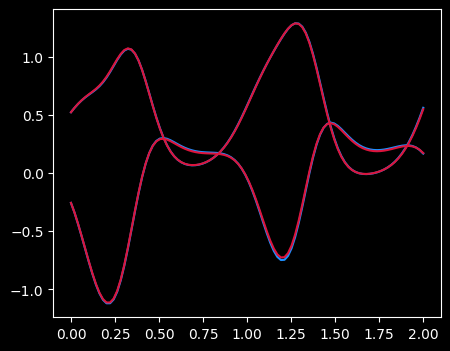

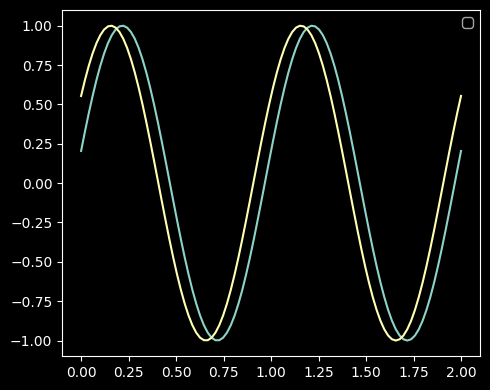

In [7]:
key = jr.PRNGKey(366)

data_key, model_key, loader_key = jr.split(key, 3)
print(data_key, key)
ts, ys, test_coeffs = get_data(1, key=data_key)

trajNo = 0
_coeffs = tuple(arr[trajNo] for arr in test_coeffs)
print(ts.shape)
interp = diffrax.CubicInterpolation(ts[0], _coeffs)
values = jax.vmap(interp.evaluate)(ts[0])

print(ts.shape)
print(ys.shape)
print(test_coeffs[1].shape)
print(values.shape)

plt.figure(figsize=(5, 4))
plt.plot(ts[trajNo], ys[trajNo, :, 1], c="dodgerblue", label="Real")
plt.plot(ts[trajNo], ys[trajNo, :, 2], c="dodgerblue")
model_y = model(ts[trajNo], ys[trajNo, 0], _coeffs)
print(model_y.shape)
plt.plot(ts[trajNo], model_y[:, 1], c="crimson", label="Model")
plt.plot(ts[trajNo], model_y[:, 2], c="crimson")

plt.figure(figsize=(5, 4))
plt.plot(ts[trajNo], values[:,1:])
plt.legend()
plt.tight_layout()
plt.savefig("neural_ode.png")
plt.show()